In [1]:
# standard library
import os

# Third-party
from astropy.constants import G
import astropy.coordinates as coord
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, join
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline
import corner
from pyia import GaiaData
import pystan
from gala.units import UnitSystem
from scipy.stats import binned_statistic_2d

In [6]:
galcen_frame = coord.Galactocentric(z_sun=0*u.pc)

In [2]:
def sech2_potential(z, sigma, hz, G):
    return 4*np.pi*G * sigma * hz * np.log(np.cosh(0.5 * z / hz))

In [3]:
units = UnitSystem(u.pc, u.Myr, u.radian, u.Msun)

## Prepare data:

In [4]:
allstar = fits.getdata('/Users/apricewhelan/data/APOGEE_DR16/allStarLite-r12-l33.fits')
allstar = Table(allstar)

xm = fits.getdata('/Users/apricewhelan/data/APOGEE_DR16/allStar-r12-gaiadr2.fits')
xm_tbl = Table()
for col in ['source_id', 'ra', 'dec', 'parallax', 'parallax_error', 'pmra', 'pmdec', 'apogee_id']:
    xm_tbl[col] = xm[col]
xm_tbl.rename_column('apogee_id', 'APOGEE_ID')

tbl = join(allstar, xm_tbl, keys='APOGEE_ID')
g = GaiaData(tbl)

In [77]:
mask = ((tbl['LOGG'] > 0.) & (tbl['LOGG'] < 3.5) &
        (tbl['TEFF'] > 4000) & (tbl['TEFF'] < 6500) & 
        (tbl['SNR'] > 50) & 
        np.isfinite(tbl['ALPHA_M']) & (tbl['ALPHA_M'] > -999) &
        ((g.parallax / g.parallax_error) > 10) & 
        (g.get_distance(allow_negative=True) < 4*u.kpc))

# ~quality cut
mask &= (np.abs(g.ALPHA_M) < 0.5)

_c = g.get_skycoord(distance=g.get_distance(allow_negative=True),
                    radial_velocity=g.VHELIO_AVG*u.km/u.s).transform_to(galcen_frame)
mask &= np.sqrt((_c.z / (2*u.kpc))**2 + (_c.v_z / (100*u.km/u.s))**2) < 1.

# HACK:
# mask &= (np.abs(g.ALPHA_M) < 0.125)
# mask &= np.sqrt((_c.z / (400*u.pc))**2 + (_c.v_z / (25*u.km/u.s))**2) > 1.

mask.sum()

112915

In [78]:
sub_g = g[mask]
c = sub_g.get_skycoord(radial_velocity=sub_g.VHELIO_AVG*u.km/u.s)
galcen = c.transform_to(galcen_frame)
elem = np.array(sub_g.ALPHA_M, dtype='f8')

In [79]:
z = galcen.z.decompose(units).value
vz = galcen.v_z.decompose(units).value
G_ = G.decompose(units).value

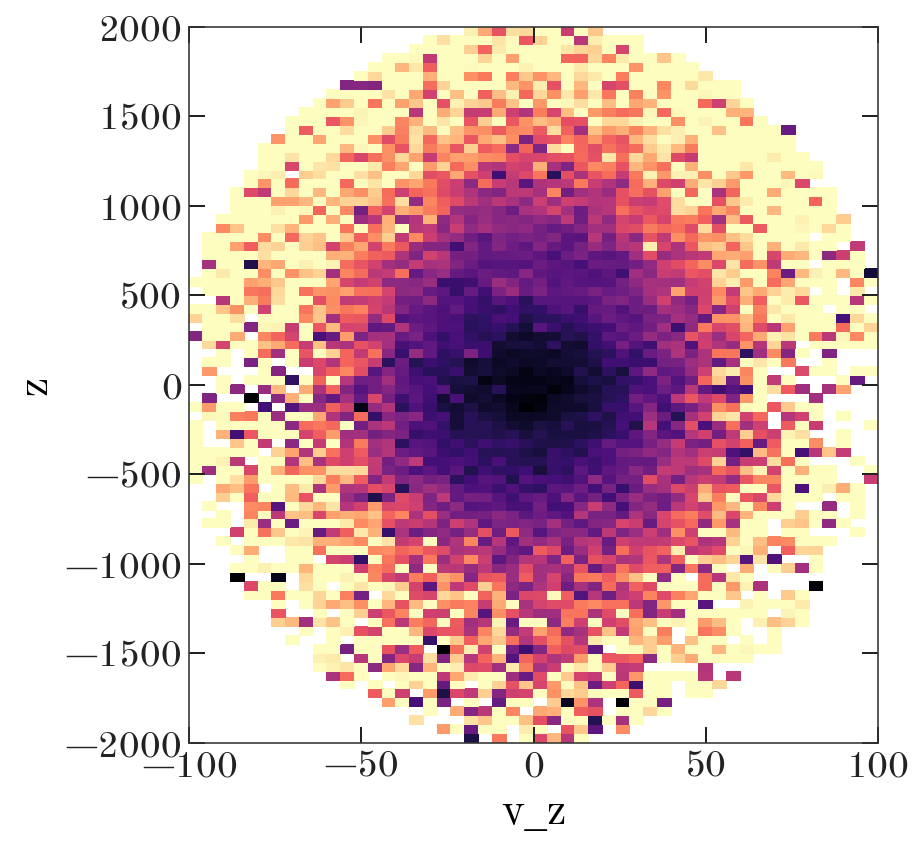

In [86]:
zlim = 2000 # pc
vlim = 100. # pc/Myr
vstep = 4
zstep = 50

fig, ax = plt.subplots(1, 1, figsize=(6.5, 6))

stat = binned_statistic_2d(vz, z, elem, statistic='mean',
                           bins=(np.arange(-vlim, vlim+1e-3, vstep),
                                 np.arange(-zlim, zlim+1e-3, zstep)))

vmin, vmax = np.percentile(elem, [15, 85])
ax.pcolormesh(stat.x_edge, stat.y_edge, stat.statistic.T, 
              cmap='magma', vmin=vmin, vmax=vmax)

ax.set_xlabel('v_z')
ax.set_ylabel('z')
fig.set_facecolor('w')
fig.tight_layout()

---

In [31]:
sm = pystan.StanModel('../stan/two_trend.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5f9d3c0c63cae370a4db758804e50137 NOW.


In [81]:
data = {'z': galcen.z.decompose(units).value,
        'v_z': galcen.v_z.decompose(units).value,
        'elem': elem,
        'n_stars': len(galcen),
        'G': G.decompose(units).value}

In [82]:
init = {'ln_Sigma': np.log(50.),
        'ln_hz': np.log(250.),
        'inv0': 0,
        'a0': 0.,
        'a1': 1e-2,
        'a2': 3e-3,
        'ln_s': np.log(0.02),
        'b0': 0.2,
        'b1': 1e-2,
        'ln_s2': np.log(0.04),
        'f_a': 0.05,
        'f_x0': 1.1,
        'f_k': -3}

(-0.4, 0.4)

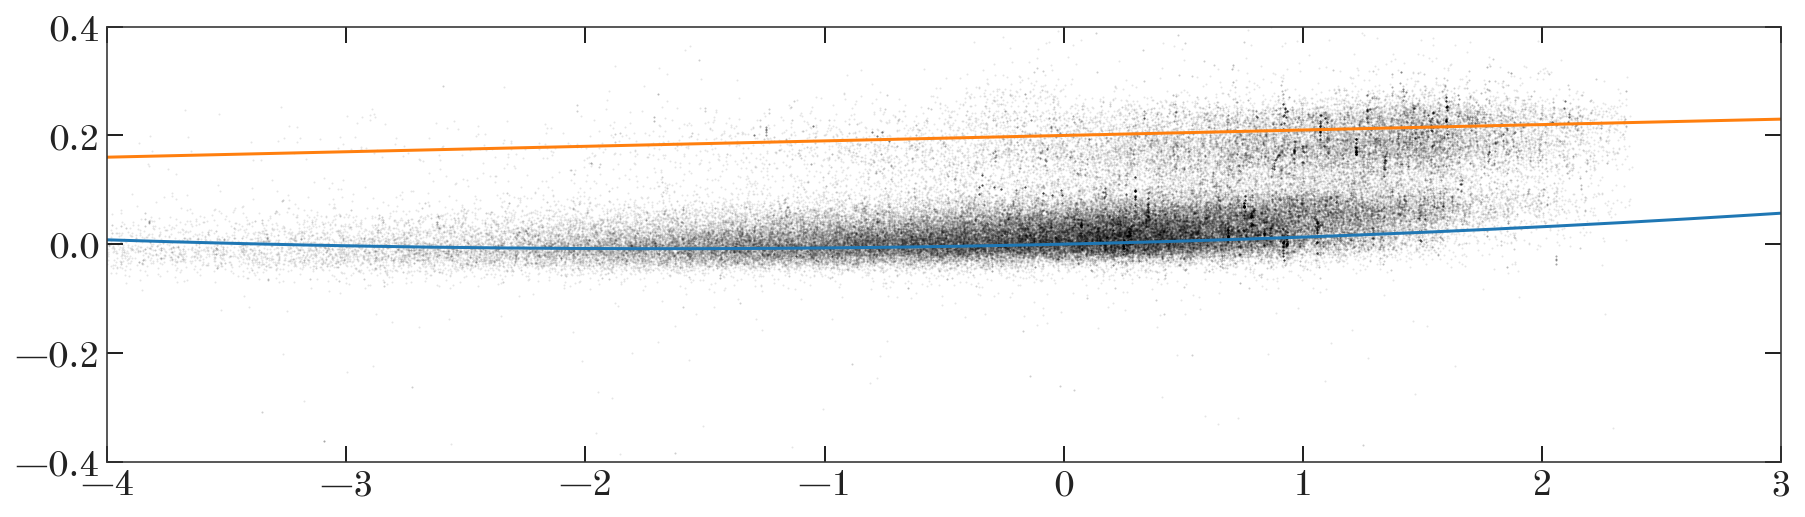

In [83]:
Ez = (0.5*data['v_z']**2 + sech2_potential(data['z'], np.exp(init['ln_Sigma']), 
                                           np.exp(init['ln_hz']), G_))
invariant = np.log(Ez) - np.mean(np.log(Ez))

fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.scatter(invariant, elem, 
           alpha=0.1, marker='o', s=1., color='k', linewidth=0)

igrid = np.linspace(-4, 3, 128)
di = igrid - init['inv0']
ax.plot(igrid, init['a0'] + init['a1']*di + init['a2']*di**2, marker='')

ax.plot(igrid, init['b0'] + init['b1']*igrid, marker='')

ax.set_xlim(-4, 3)
ax.set_ylim(-0.4, 0.4)

In [84]:
fit = sm.optimizing(data, init=init)

In [85]:
fit

OrderedDict([('sun_z', array(44.38917626)),
             ('sun_vz', array(-52.29299861)),
             ('ln_Sigma', array(4.19756481)),
             ('ln_hz', array(5.67293997)),
             ('ln_s', array(-3.6129546)),
             ('inv0', array(-0.00083317)),
             ('a0', array(0.01682325)),
             ('a1', array(0.01330079)),
             ('a2', array(0.00169708)),
             ('b0', array(0.1373101)),
             ('b1', array(0.02376866)),
             ('ln_s2', array(-2.68048923)),
             ('f_x0', array(1.03373479)),
             ('f_k', array(-2.79541035)),
             ('f_a', array(0.09648449)),
             ('s', array(0.02697204)),
             ('s2', array(0.06852962)),
             ('hz', array(290.8884814)),
             ('Sigma', array(66.52413441)),
             ('Ez',
              array([ 847.85110517,  297.3355752 , 1299.64991252, ...,   29.27785764,
                     2513.80660187,  270.58343567])),
             ('invariant',
              arr

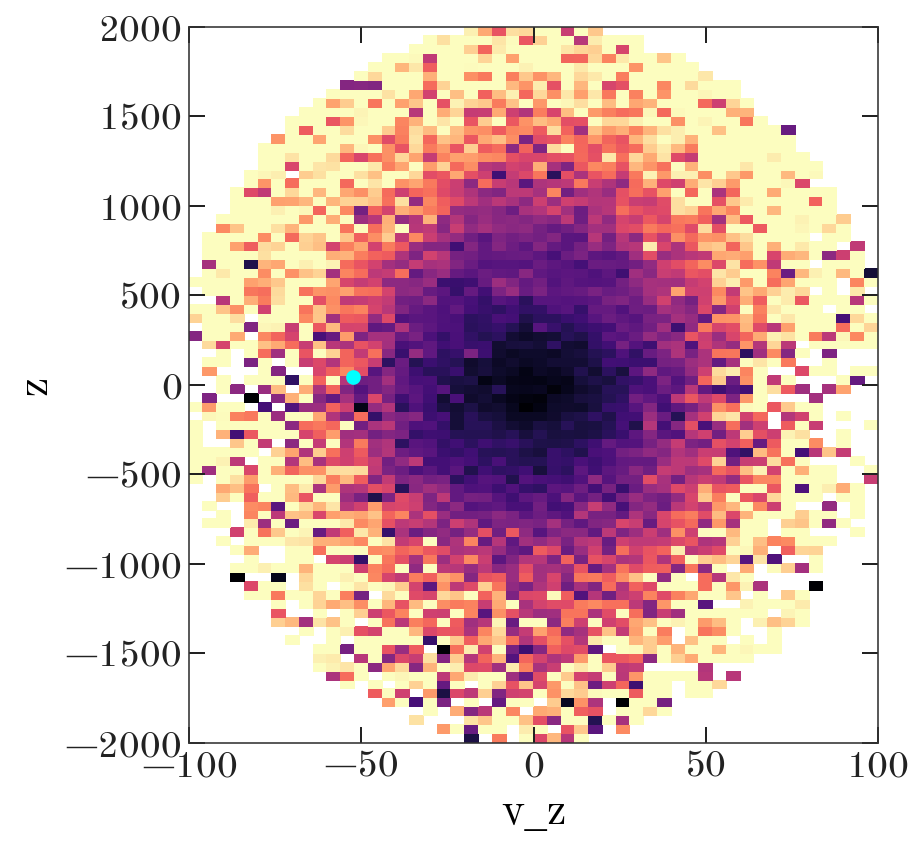

In [95]:
zlim = 2000 # pc
vlim = 100. # pc/Myr
vstep = 4
zstep = 50

fig, ax = plt.subplots(1, 1, figsize=(6.5, 6))

stat = binned_statistic_2d(vz, z, elem, statistic='mean',
                           bins=(np.arange(-vlim, vlim+1e-3, vstep),
                                 np.arange(-zlim, zlim+1e-3, zstep)))

vmin, vmax = np.percentile(elem, [15, 85])
ax.pcolormesh(stat.x_edge, stat.y_edge, stat.statistic.T, 
              cmap='magma', vmin=vmin, vmax=vmax)

ax.scatter(fit['sun_vz'], fit['sun_z'], s=40, color='cyan')

ax.set_xlabel('v_z')
ax.set_ylabel('z')
fig.set_facecolor('w')
fig.tight_layout()

In [88]:
# samples = sm.sampling(data, init=[fit], chains=1)

In [89]:
_bins = np.arange(-4, 3+1e-3, 0.2)
H1, *_ = np.histogram(invariant[elem < 0.12], bins=_bins)
H2, *_ = np.histogram(invariant[elem >= 0.12], bins=_bins)

/Users/apricewhelan/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


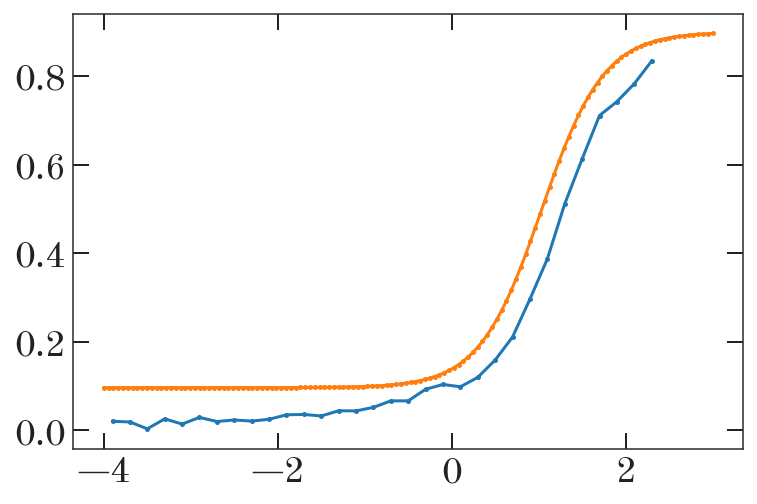

In [90]:
plt.plot(0.5*(_bins[:-1]+_bins[1:]), H2 / (H1 + H2))
_grid = np.linspace(-4, 3, 128)
_x0 = 1.1
# plt.plot(_grid, 0.05 + (0.9-0.05) / (1 + np.exp(-3 * (_grid - _x0))))
plt.plot(_grid, fit['f_a'] + (0.9-fit['f_a']) / (1 + np.exp(fit['f_k'] * (_grid - fit['f_x0']))))

(-0.4, 0.4)

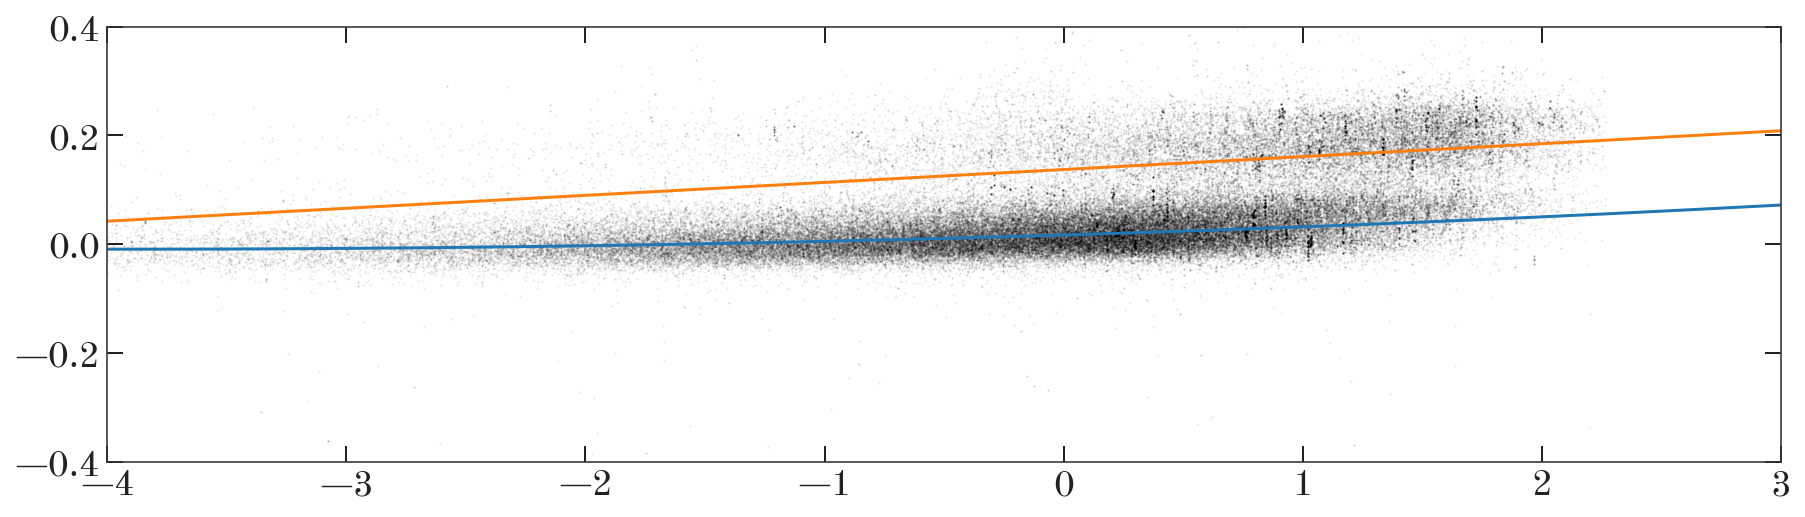

In [91]:
Ez = (0.5*data['v_z']**2 + sech2_potential(data['z'], np.exp(fit['ln_Sigma']), 
                                           np.exp(fit['ln_hz']), G_))
invariant = np.log(Ez) - np.mean(np.log(Ez))

fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.scatter(invariant, elem, 
           alpha=0.1, marker='o', s=1., color='k', linewidth=0)

igrid = np.linspace(-4, 3, 128)
di = igrid - fit['inv0']
ax.plot(igrid, fit['a0'] + fit['a1']*di + fit['a2']*di**2, marker='')

ax.plot(igrid, fit['b0'] + fit['b1']*igrid, marker='')

ax.set_xlim(-4, 3)
ax.set_ylim(-0.4, 0.4)